In [1]:
import os, glob
from copy import deepcopy
import numpy as np
import pandas as pd
import corner
import h5py
import prospect.io.read_results as reader
import matplotlib.pyplot as plt

In [2]:
def computeConfidenceIntervals(result, alphas=[0.682, 0.954, 0.996], **kwargs):
    '''
    result dictionary from prospector
    '''
    chain, labels = result['chain'], result['theta_labels']
    return {str(a):CI(chain, labels, a, **kwargs) for a in alphas}                                        


def CI(chain, labels, alpha, verbose=False, log=None):
    '''
    Calculate the confidence intervals around the median
    of each input parameter in the chain
    
    chain [Array] : np array of output samples from the MCMC
    alpha [float] : confidence level to compute
    center [string] : techniique to get central value of distribution
                      that the CI is based around. Supported options are
                      'median', 'mode', 'mean'
    '''
    
    if log is None:
        log = [False]*len(labels) # don't log any of the labels
    
    forFile = 'Confidence Intervals: \n\n'
    outdict = {}
    for col, label, isLogged in zip(chain.T, labels, log):
        
        if isLogged:
            col = np.log10(col)
            label = f'log10({label})'
        
        middle = 0.5
        q1 = np.quantile(col, middle-(alpha/2))
        q2 = np.quantile(col, middle)
        q3 = np.quantile(col, middle+(alpha/2))
        
        forFile += f'{label} {alpha*100}% CI:\n'
        if verbose:
            forFile += f'         Q1: {q1}\n'
            forFile += f'Q2 (median): {q2}\n'
            forFile += f'         Q3: {q3}\n'
        forFile += f'{label} = {q2} (+{q3-q2}, -{q2-q1})'
        forFile += '\n'
        
        outdict[label] = {'median':q1,
                          'negErr':q2-q1,
                          'posErr':q3-q2}
        
    #print(forFile)
    
    return outdict 

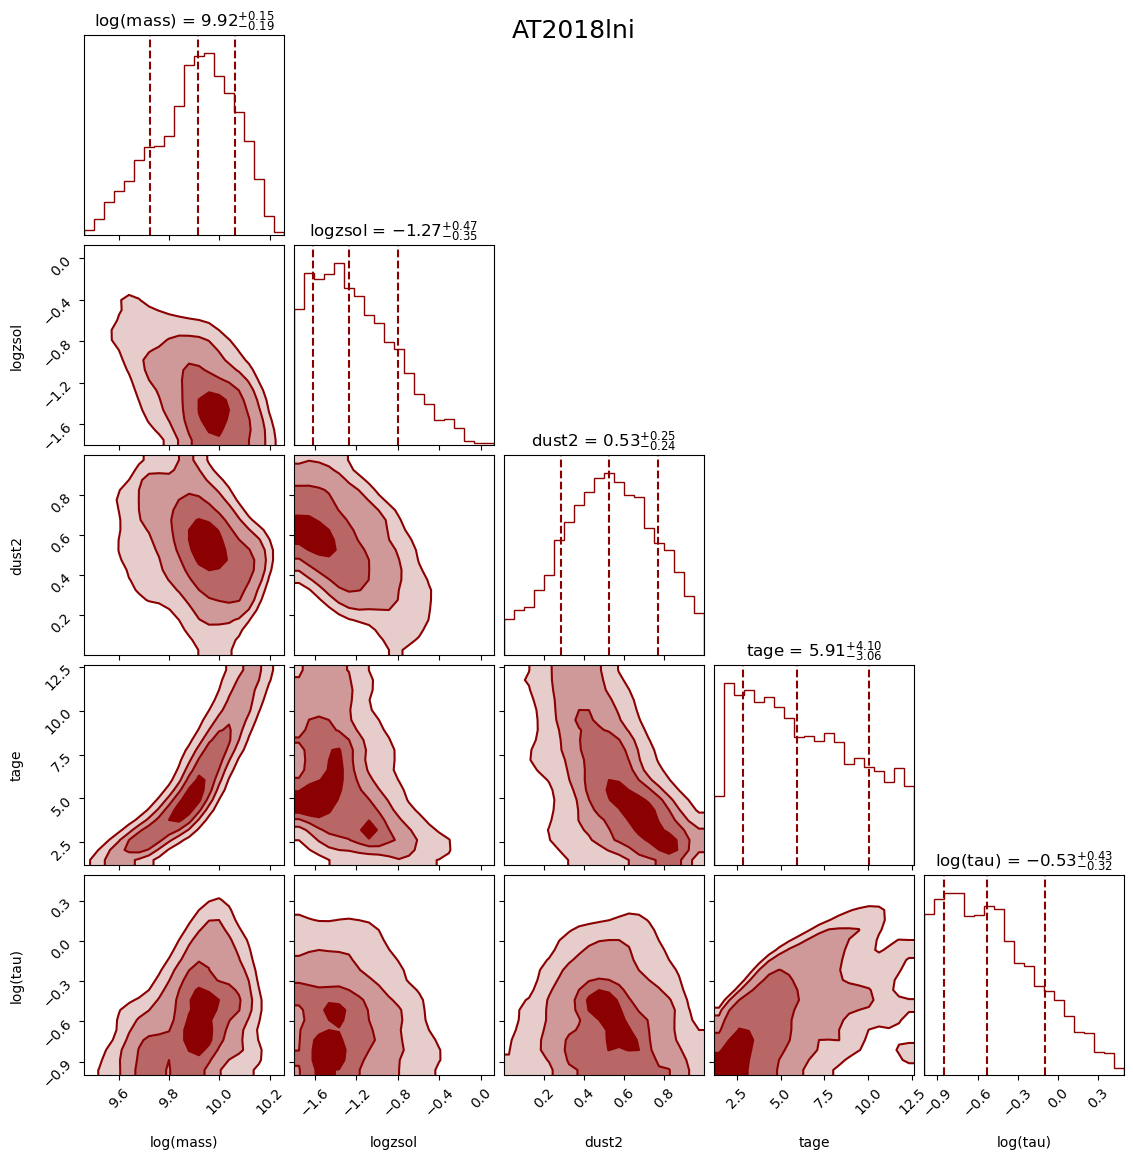

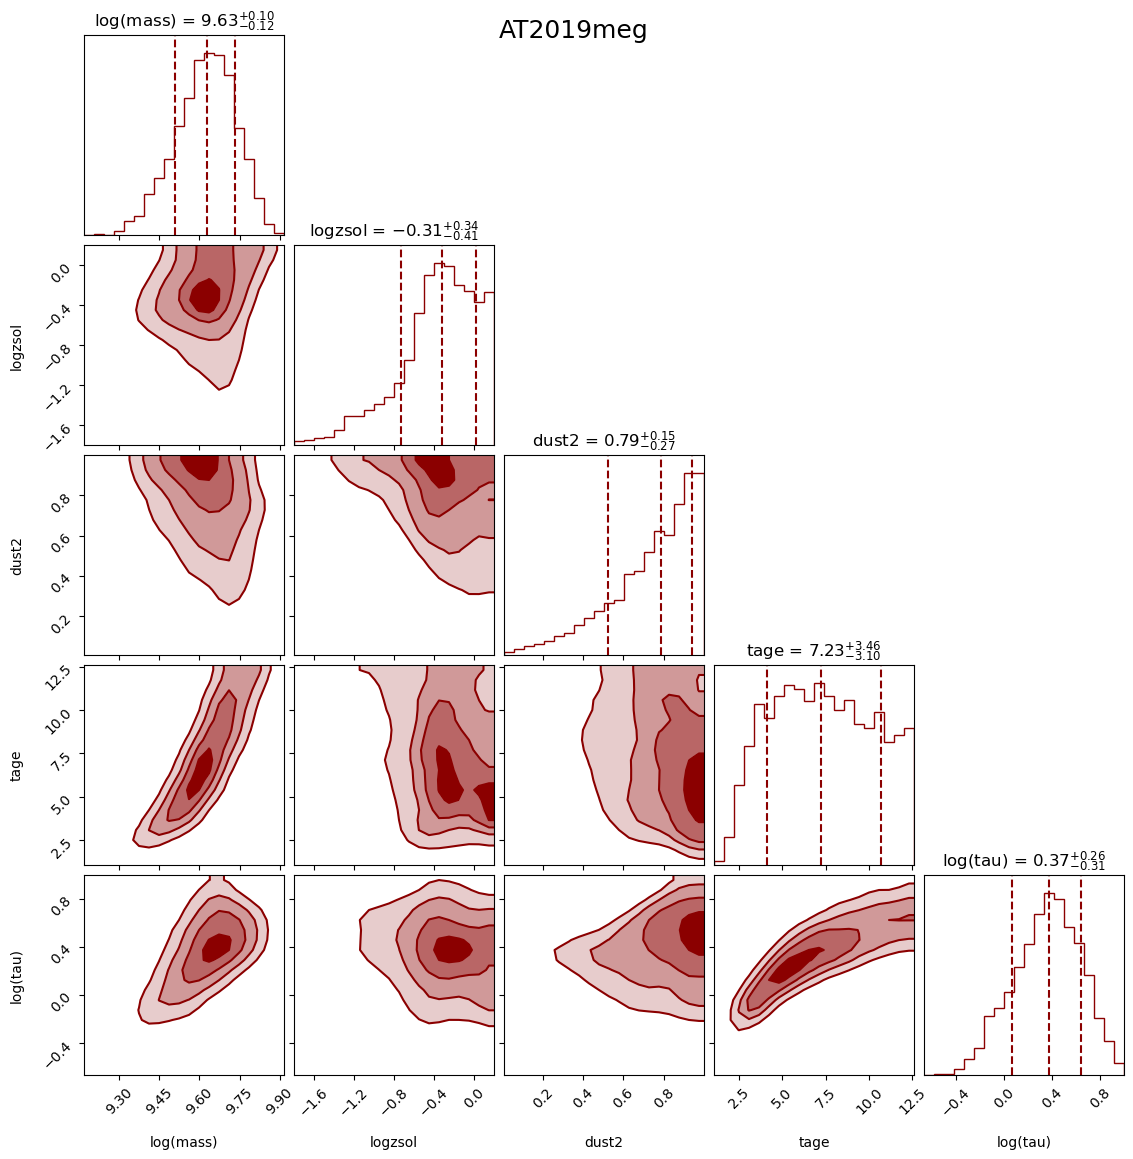

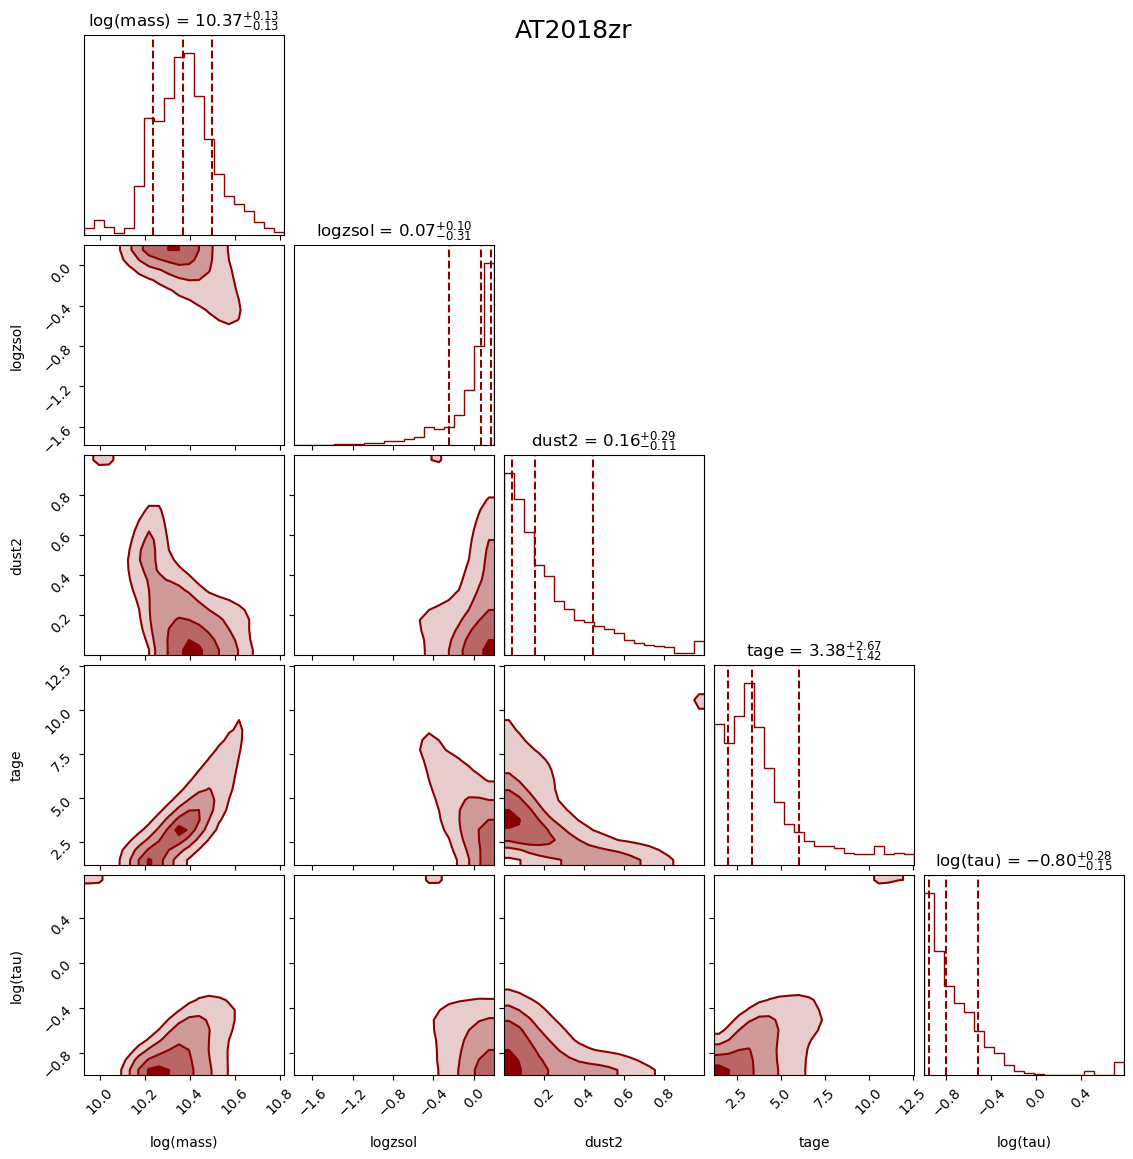

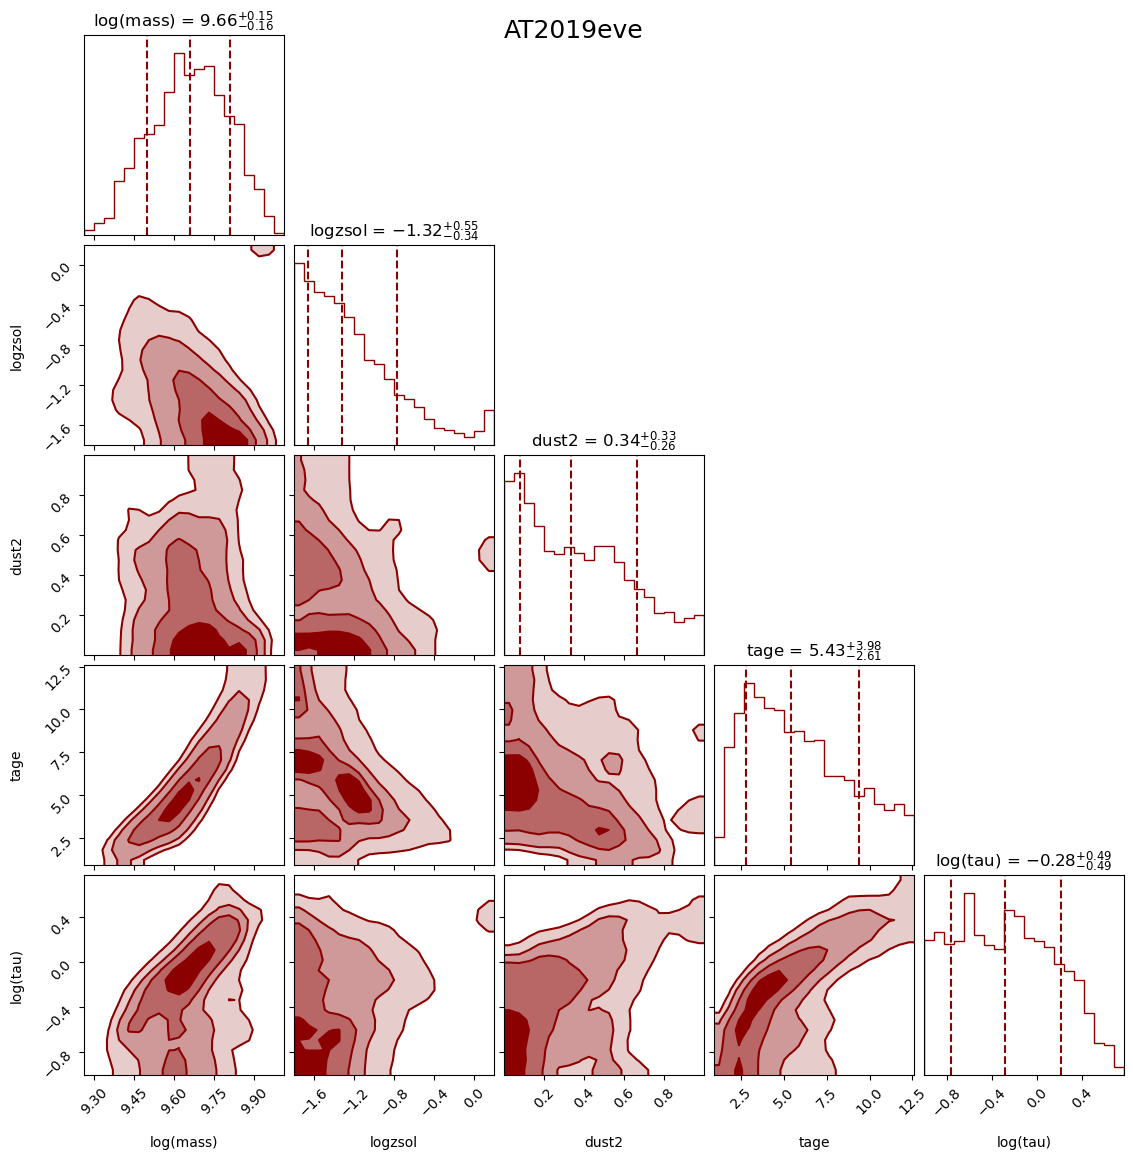

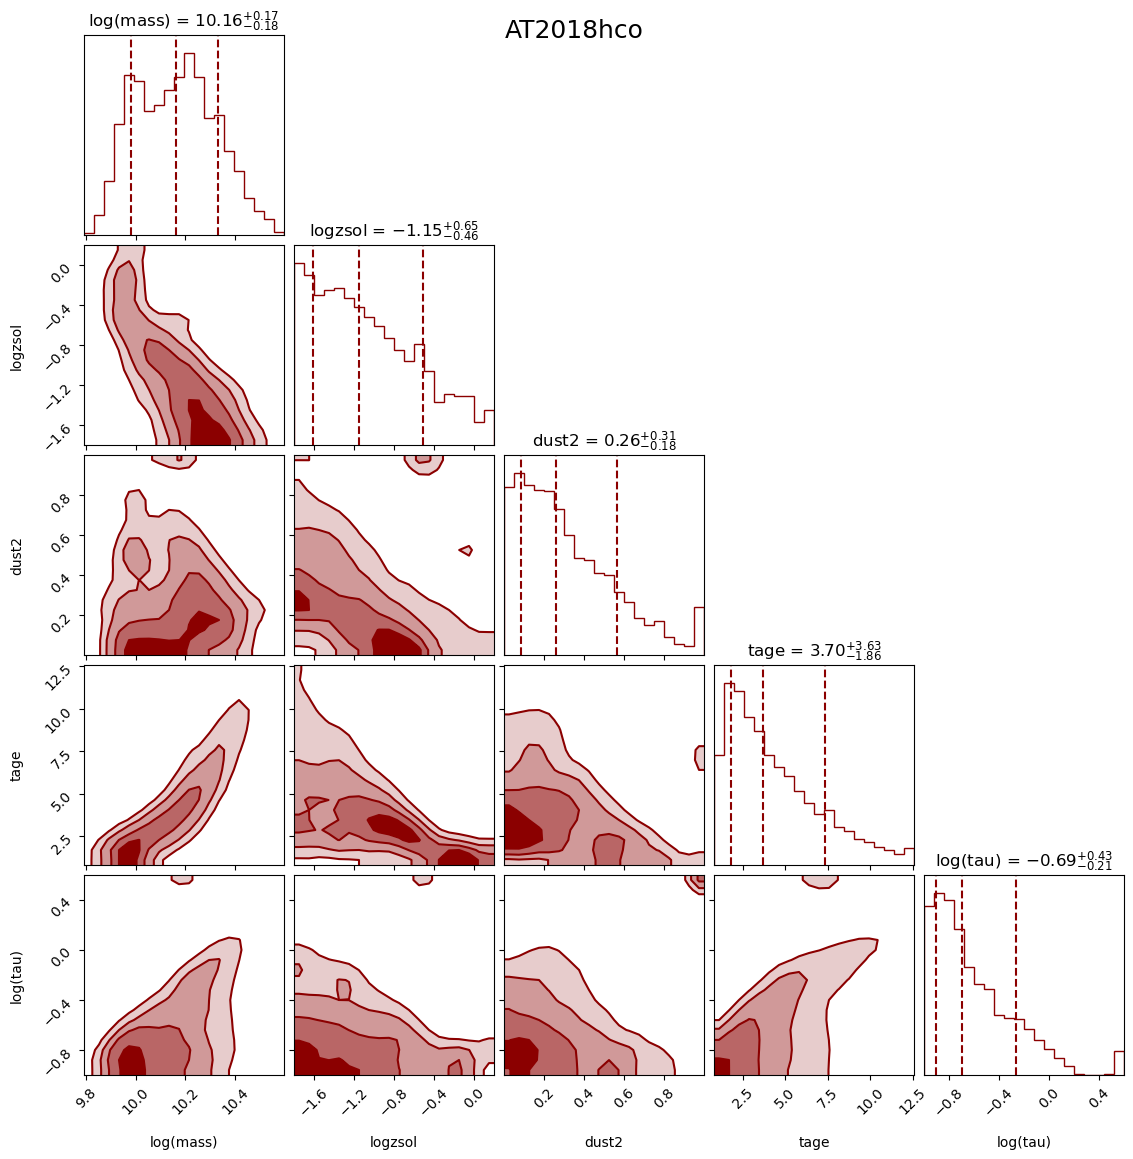

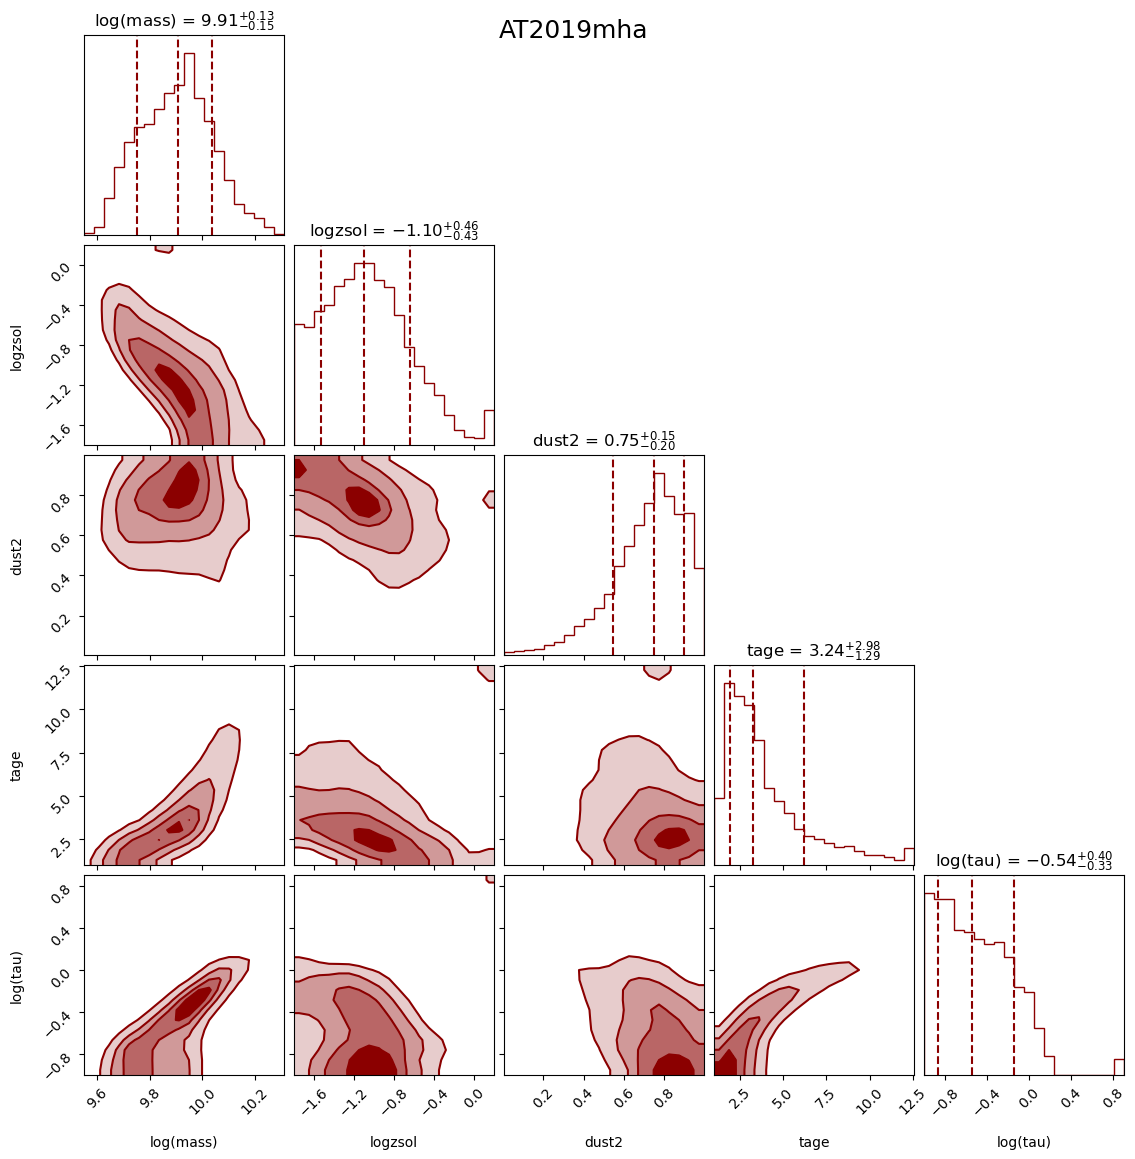

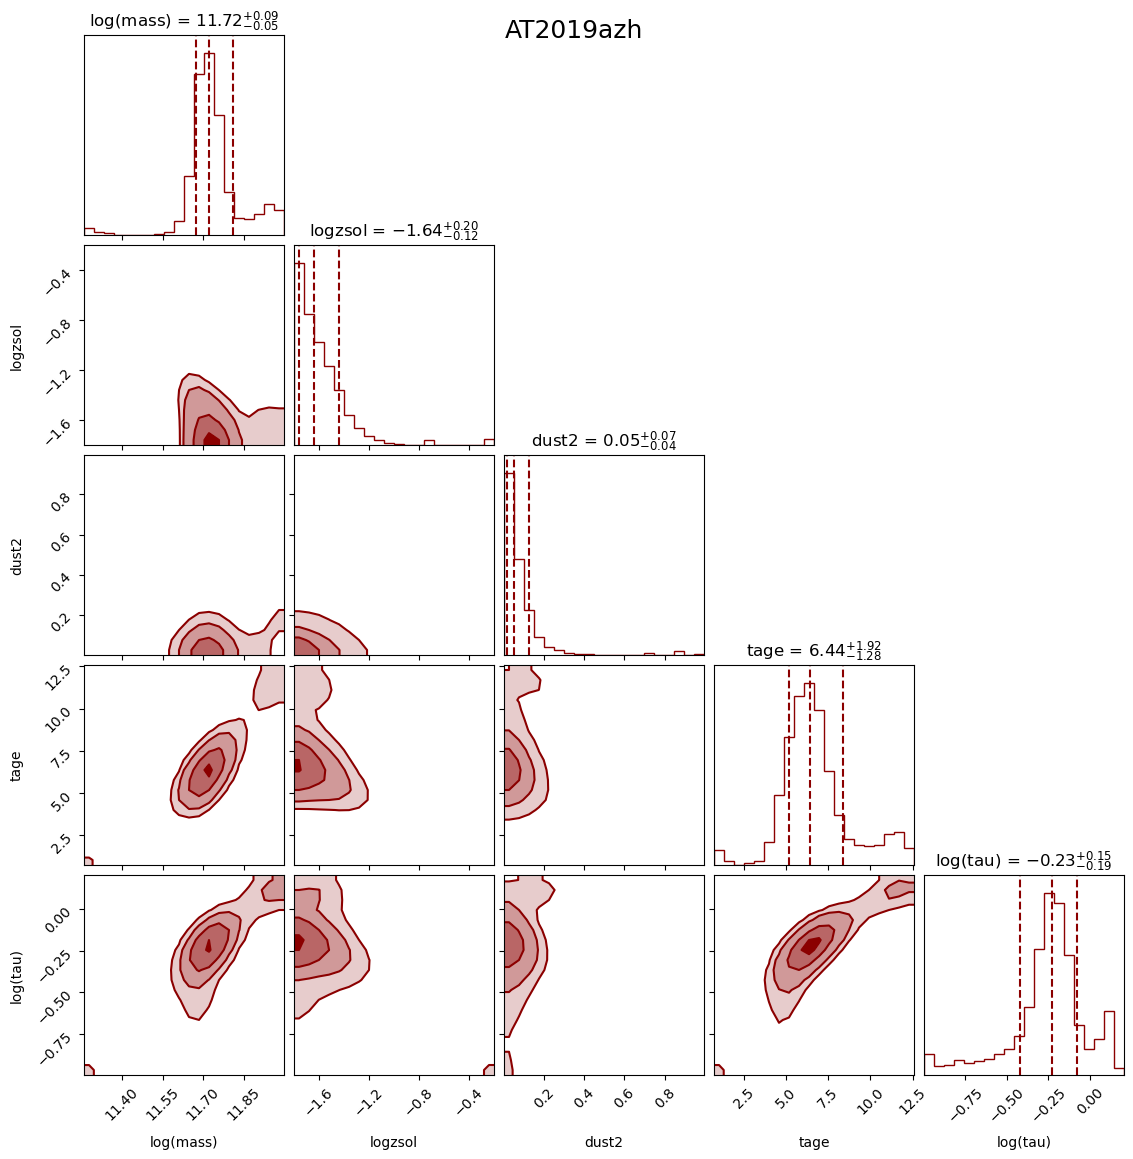

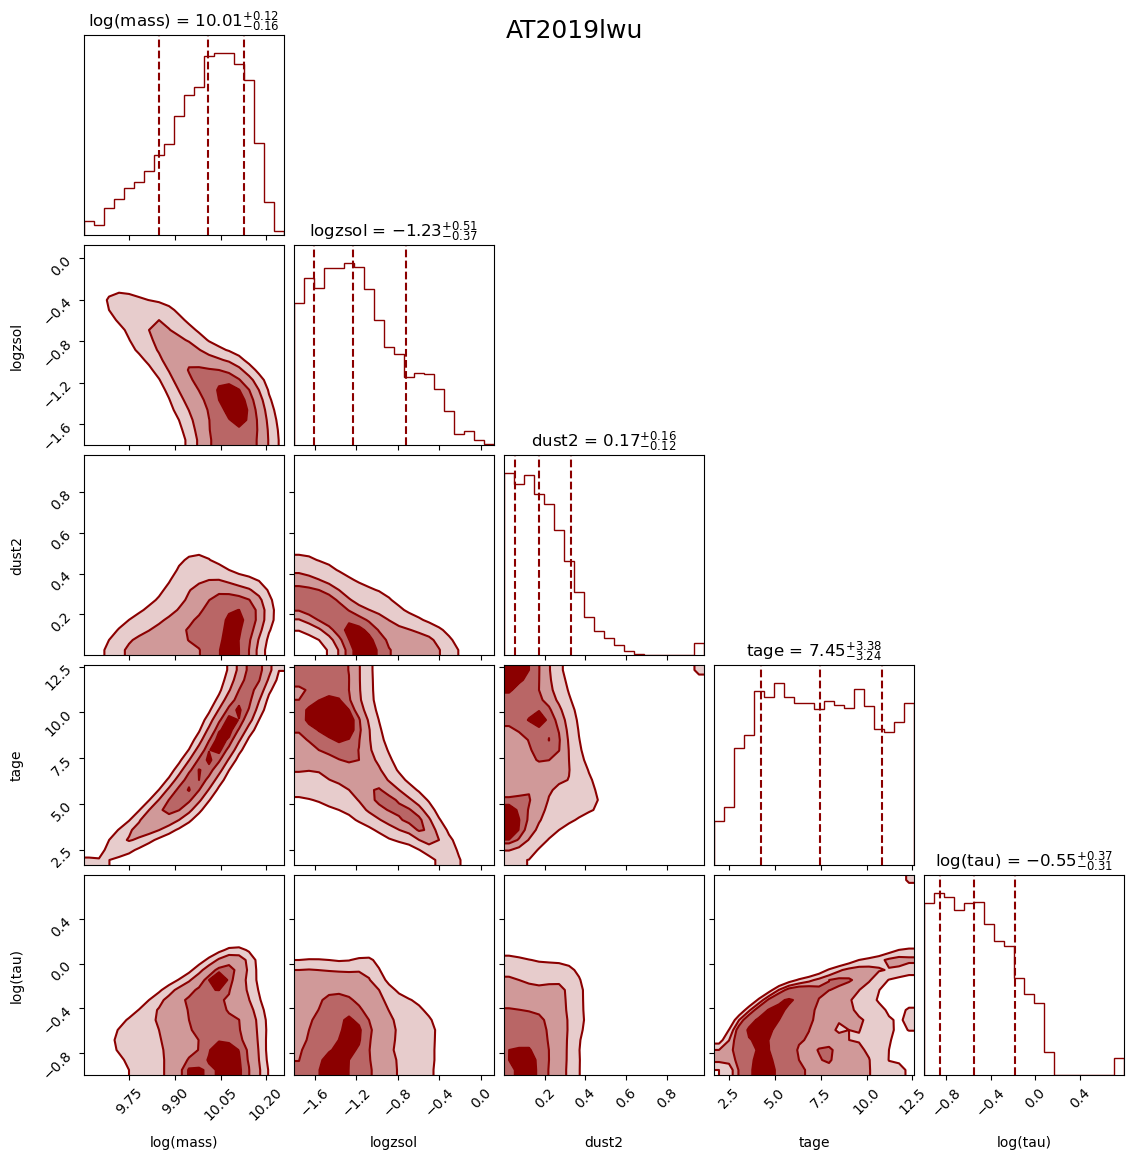

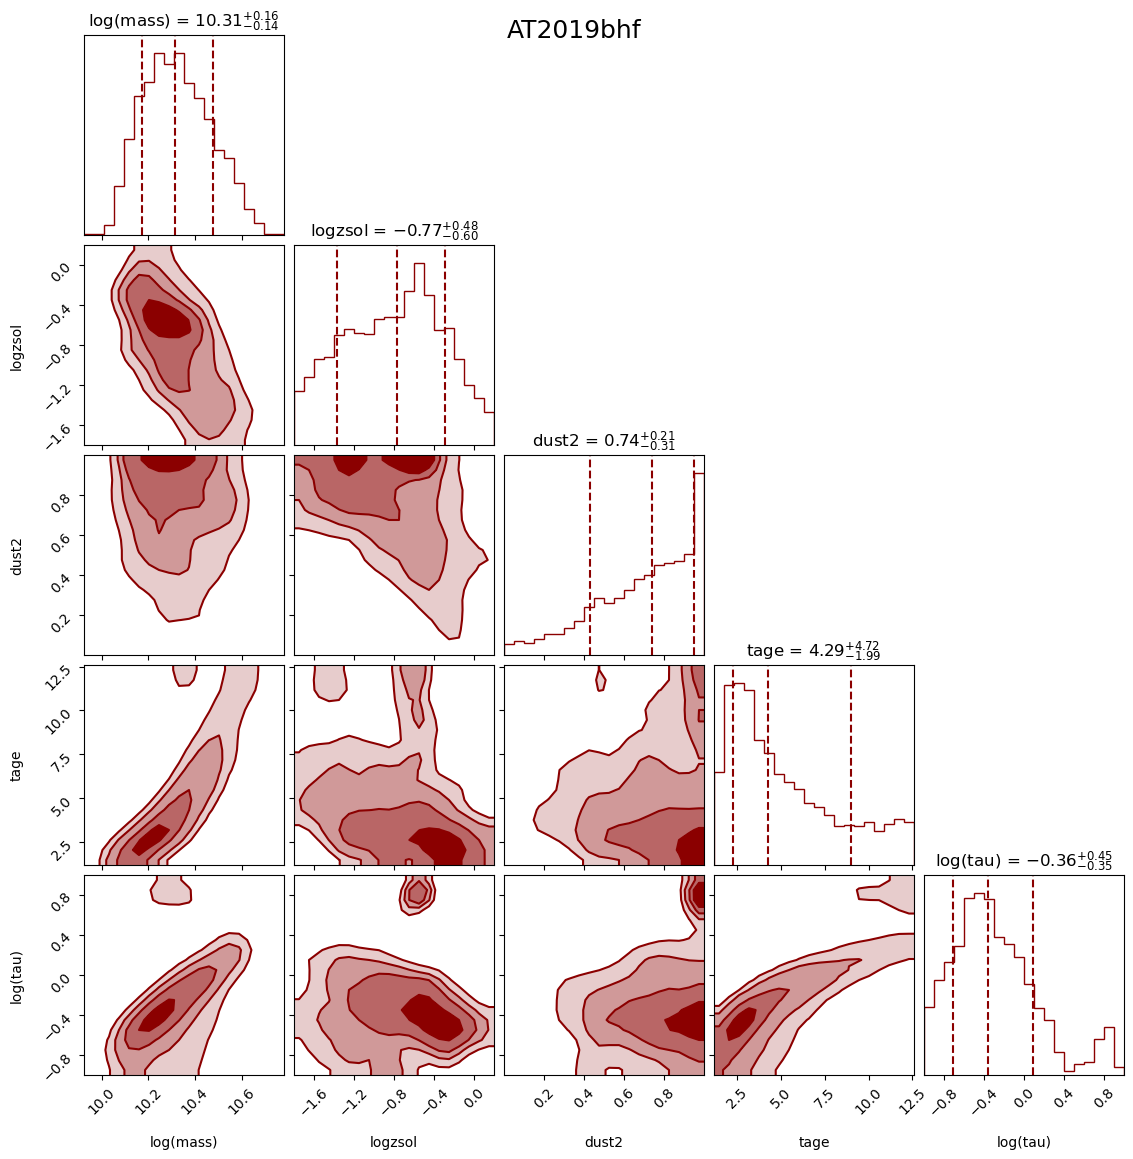

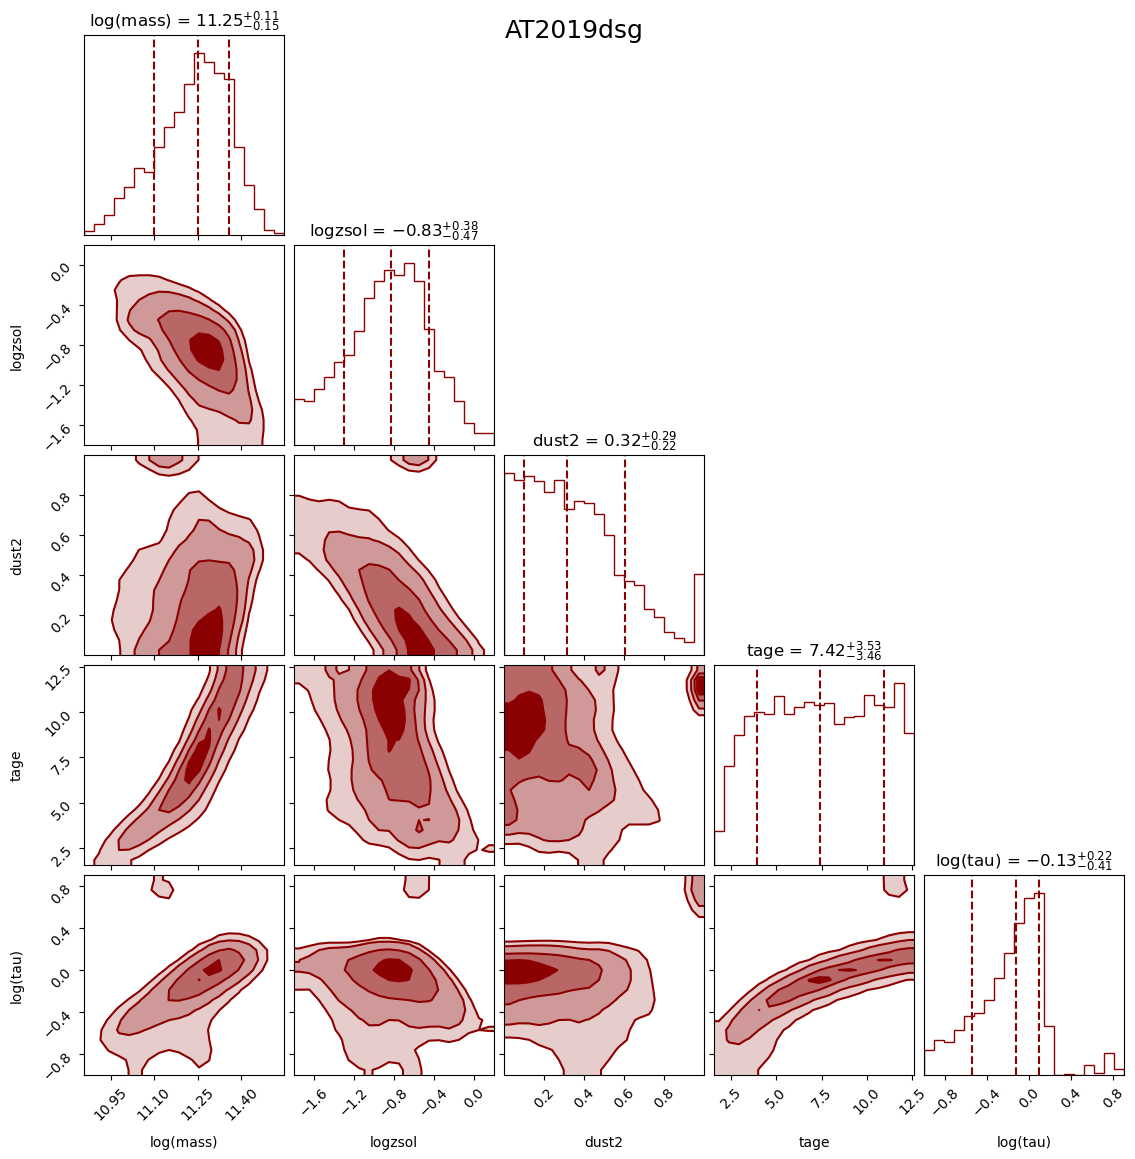

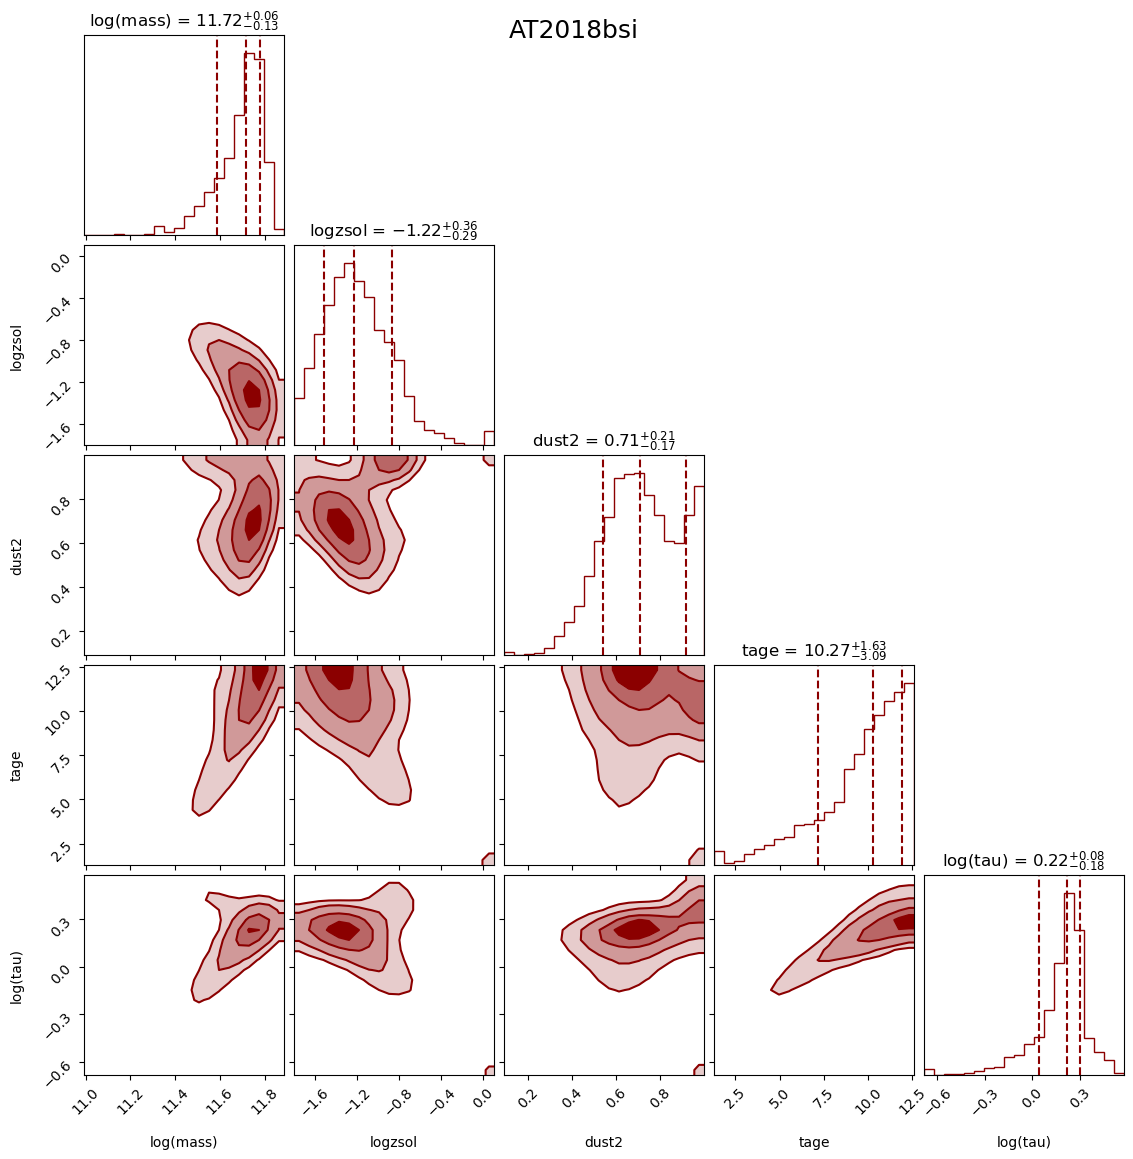

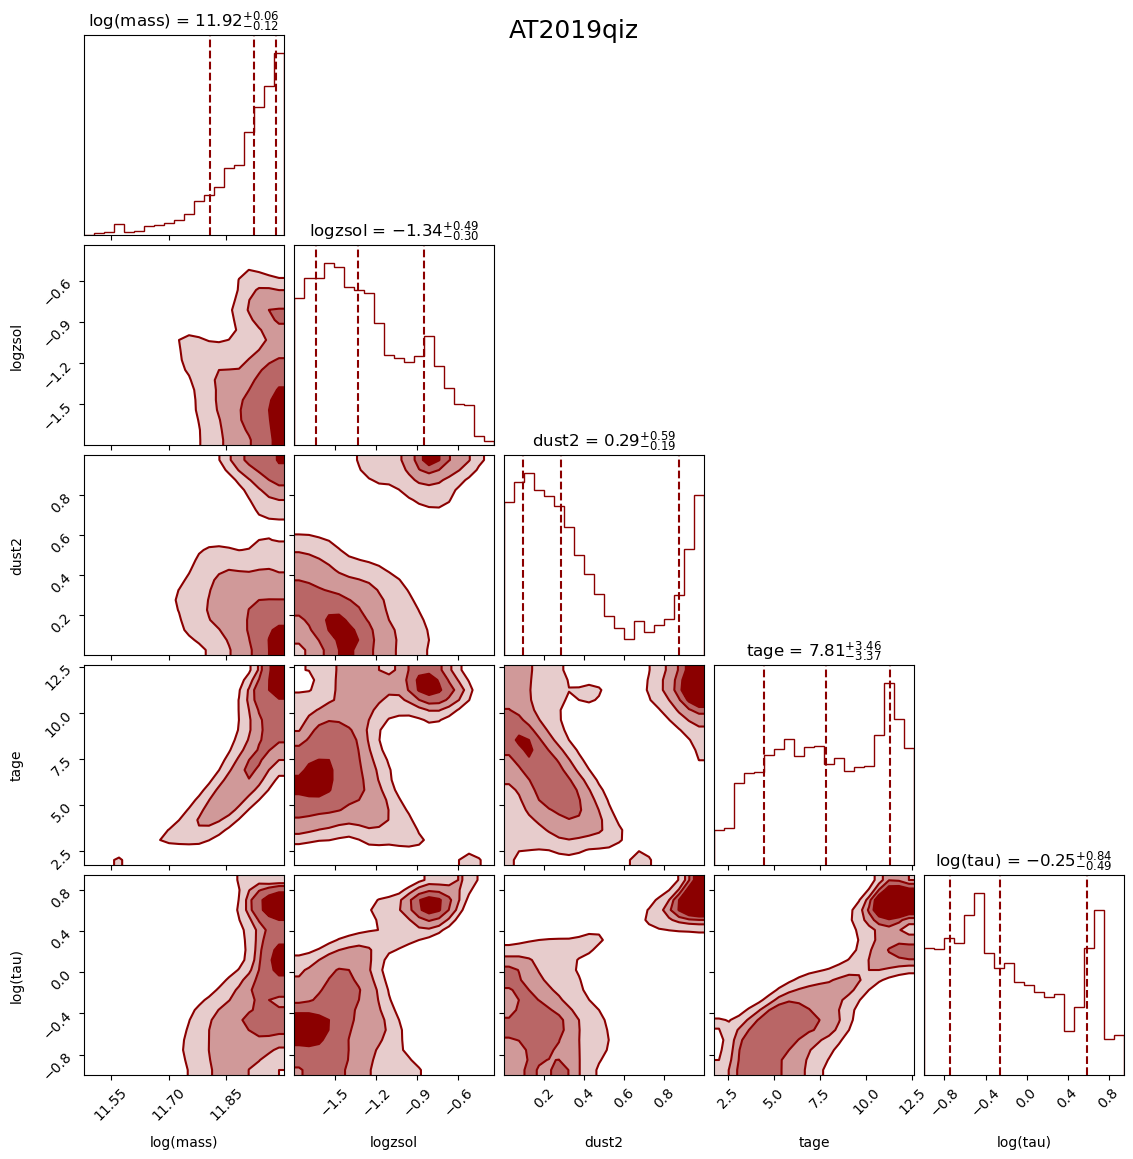

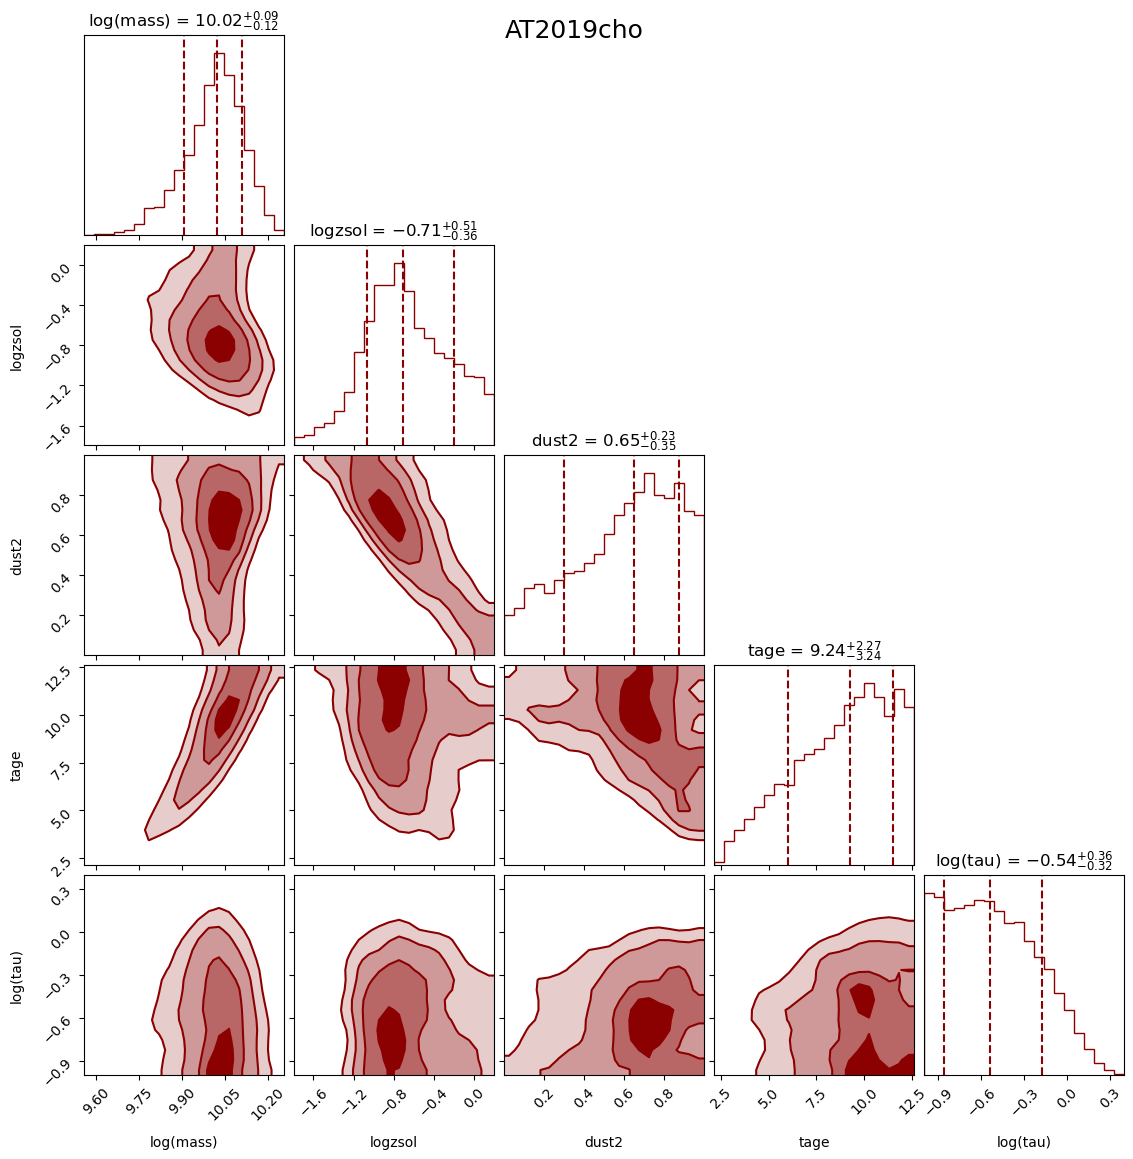

In [3]:
outdir = os.path.join(os.getcwd(), 'data', 'out', '*h5')
outfiles = glob.glob(outdir)

allci = {}
for h5file in outfiles:
    res, obs, model = reader.results_from(h5file)

    cfig = reader.subcorner(res, logify=['mass', 'tau'], bins=20, smooth=1, color='darkred')
    cfig.suptitle(obs['objid'], fontsize=18)

    log = [True, False, False, False, False]
    ci = computeConfidenceIntervals(res, alphas=[0.682], log=log)
    
    allci[obs['objid']] = ci['0.682']

## Comparing Median Values

In [4]:
subdict = {'median':[],
            'negErr':[],
             'posErr':[]}

dfdict = {'log10(mass)':deepcopy(subdict),
          'logzsol':deepcopy(subdict),
          'dust2':deepcopy(subdict),
          'tage':deepcopy(subdict),
          'tau':deepcopy(subdict),
          'names':[]}

for tde in allci:
    for key in dfdict:
        if key == 'names':
            dfdict[key].append(tde)
        else:
            for subkey in subdict:
                dfdict[key][subkey].append(allci[tde][key][subkey])

In [5]:
for key in dfdict:
    if key == 'names': continue
    dfdict[key] = pd.DataFrame(dfdict[key])
    dfdict[key]['name'] = dfdict['names']

In [16]:
true = {'true_mass':deepcopy(subdict),
       'true_z': deepcopy(subdict),
       'true_dust': deepcopy(subdict),
       'true_age': deepcopy(subdict),
       'true_tau': deepcopy(subdict),
       'name':[]}

truedata = pd.read_csv('data/catalog.txt', skiprows=7, delimiter='\t', 
                       names=['name', 'true_mass', 'u_r', 'true_dust', 'true_age', 'true_tau', 'true_z'],
                       usecols=range(7),
                      index_col=None)

for key in true:
    for val in truedata[key]:
        
        if key == 'name':
            true['name'].append(val)
            continue
        
        split1 = val.split('_')
        split2 = split1[1].split('^')

        med = split1[0][2:-1]
        if med[0] == '{':
            med = float(med.replace('{', '-'))
        else:
            med = float(med)

        upper = float(split2[0][1:-1])
        lower = float(split2[1][1:-2])
        
        true[key]['median'].append(med)
        true[key]['negErr'].append(lower)
        true[key]['posErr'].append(upper)

for key in true:
    if key == 'name': continue
    true[key] = pd.DataFrame(true[key])
    true[key]['name'] = true['name']    

In [17]:
true.keys(), dfdict.keys()

(dict_keys(['true_mass', 'true_z', 'true_dust', 'true_age', 'true_tau', 'name']),
 dict_keys(['log10(mass)', 'logzsol', 'dust2', 'tage', 'tau', 'names']))

In [18]:
comb = {}
keys = ['log10(Mass)', 'Z', 'Dust', 'Age', 'tau']
for d, t, key in zip(dfdict.values(), true.values(), keys):
    df = pd.merge(d, t, on='name', suffixes=['_Franz', '_vanVelzen']) 
    comb[key] = df

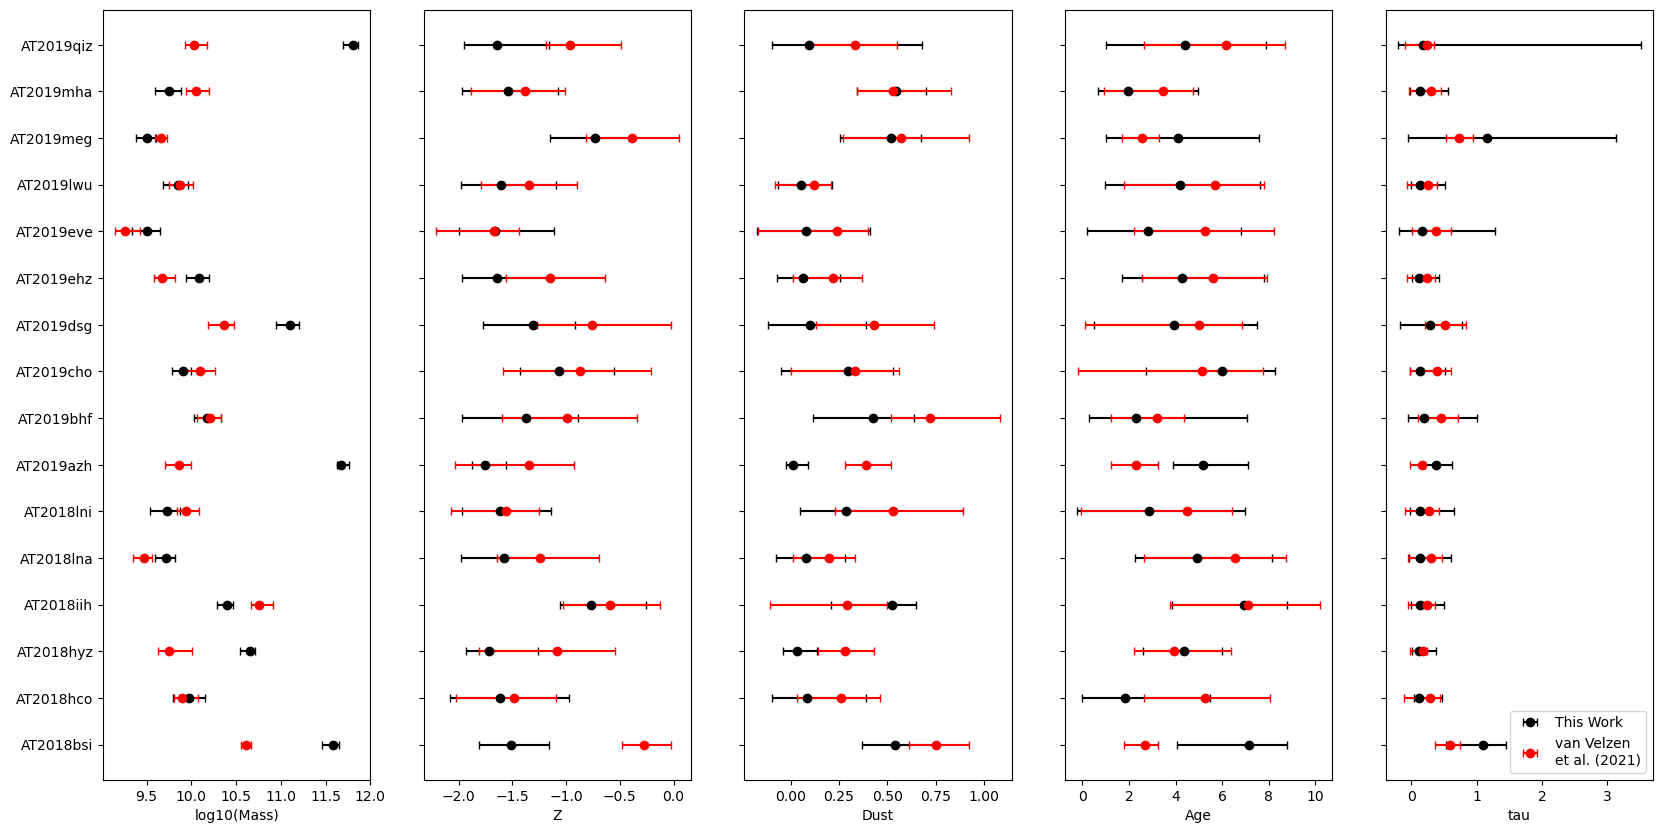

In [29]:
fig, ax = plt.subplots(1,5, sharey=True, figsize=(20,10))
for ii, key in enumerate(comb):
    df = comb[key].sort_values('name', inplace=False)
    ax[ii].errorbar(df.median_Franz, df.name, xerr=[df.negErr_Franz, df.posErr_Franz], fmt='ko', label='This Work', capsize=3)
    ax[ii].errorbar(df.median_vanVelzen, df.name, xerr=[df.negErr_vanVelzen, df.posErr_vanVelzen], fmt='ro', label='van Velzen\net al. (2021)', capsize=3)
    ax[ii].set_xlabel(key)
    
ax[ii].legend(ncols=1, loc='lower right')